# Bokeh Development Quickstart

By Gaelen Merritt @ [Aqua Insight](https://sites.google.com/aqua-insight.com/profile/home)

## Key Resources

- Bokeh Documentation (see user guide and gallery) --> https://docs.bokeh.org/en/latest/
- Bokeh Discourse (forum for usage questions) --> https://discourse.bokeh.org/
- Bokeh Github --> https://github.com/bokeh/bokeh

## Overview

Bokeh is a python library for creating interactive visualizations/applications in modern web browsers. It operates on a paradigm of instantiation of models, which serve as the "building blocks" that comprise a web application. These models are translated to a javascript-equivalent to build the application on a web browser. While bokeh can accomplish user interaction server-side (i.e. user makes an action, that request is sent a server, python code is run by the server, and the result is sent back to the user), a key advantage of bokeh is its ability to generate "standalone" applications through client-side interactivity (i.e. user makes an action, and their web browser computer executes javascript code). 

Bokeh is extremely flexible, customizable and extensible. There are not only various development workflows possible, there are also multiple data/interaction "structures" that can be used to accomplish the same goal. For this reason it can be rather overwhelming to a beginner, but the best way to learn is by trying different options and looking at documentation/existing discourse questions/threads for how to implement them.

## General Workflow

A rough "suggested" workflow for developing hydrogeology education orientation is as follows:

1. Define the figures
    - Including figure sizing, formatting, titles, axis labels, etc.
2. Define the datasources
    - ColumnDataSource as the core model for this but custom DataModels exist as well.
3. Define the glyphs/renderers
    - Includes formatting, filtering, and (most importantly) defining which datasources drive which renderers
4. Define the widgets
    - Sliders, numerical inputs, buttons, checkboxes, etc.
5. Define the interactivity. Generally this involves:
    - passing the models you want to interact in as args to a CustomJS model;
    - writing javascript code to execute that manipulates the models as desired; and
    - defining on what user interaction to trigger that code for
6. Create a layout
    - assembling all the figures/widgets into a cohesive application layout. Columns, rows, tabs, etc.
7. Write the application to standalone output
8. Embed the html on a website and/or web-application framework (e.g. streamlit)


## Example: Ogata Banks (1961) 1D ADE Analytical Solution

From https://techlabs.amphos21.com/post/ogata-and-banks-analytical-solution/ :

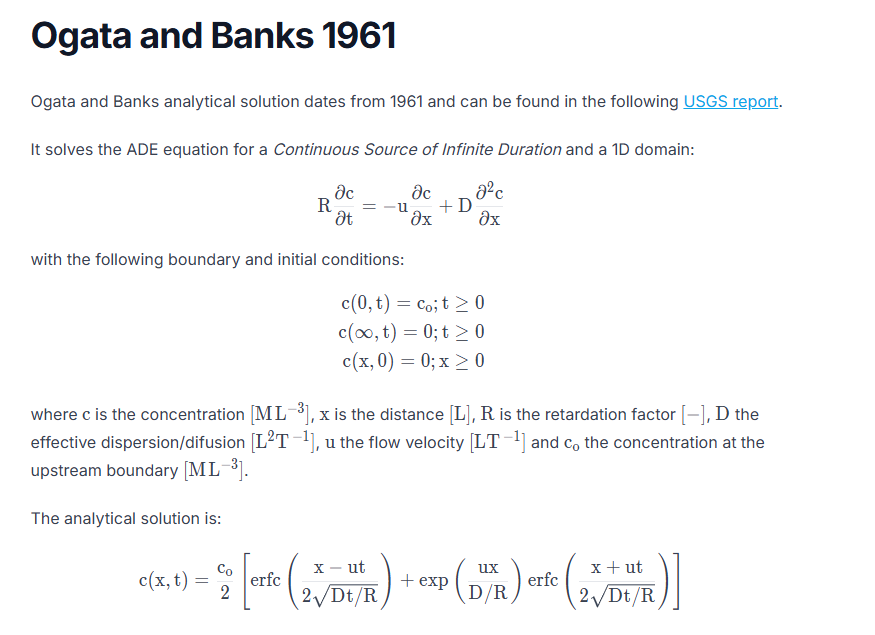

This 1D solution describes contaminant concentration in groundwater at a distance x from a constant concentration source and at time t, as a function of groundwater velocity, dispersivity/diffusion and retardation (i.e. sorption). We'll build a simple bokeh application to explore this solution.

The application "idea" is to make velocity, dispersivity/diffusivity, retardation factor, and time as adjustable parameters, and to see the resulting effect on concentration over distance from source. Obviously this could be expanded and made far more complex (e.g. looking at concentration over time at a given distance etc.), but we'll keep this one as simple as possible for bokeh-workflow purposes.


In [1]:
#import libraries, including the models we'll use

from bokeh.io import output_notebook #this is for viewing bokeh app in this notebook
from bokeh.plotting import figure, show, save
from bokeh.models import ColumnDataSource, CustomJS, Slider
from bokeh.layouts import column
output_notebook()

Loading BokehJS ...

In [2]:
#build figure and formatting
f = figure(width=800,height=600,title='Ogata Banks 1D Analytical Solution'
           ,y_range=[-0.05,1.05],x_range=[0,500] #hard coded axis bounds for simplicity's sake
          )
f.xaxis[0].axis_label = 'Distance From Source (m)'
f.yaxis[0].axis_label = 'C/Co Concentration'

In [3]:
#define the datasource (i.e. the data that will drive the line on the figure)
src = ColumnDataSource(data={'d':[]
                             ,'c':[]
                            }) #empty arrays of data for now, but will be populated when user makes an interaction

In [4]:
#define the glyphs/renderers --> just a single line added to the figure
#the way this works: "line" is a convenience method on the figure model
#this allows you to add a line glyph to the figure as a renderer in one line of code
#you tell it to use the ColumnDataSource (CDS), 
#and for the line's x values to be sourced from the "d" field in src, and the line's y values to be sourced from the "c" field in src
#so initially, this won't plot anything because i've instantiated src to have empty arrays for d and c
#but, when the user makes an action, we'll trigger JS code to UPDATE src, which will in turn update the line renderer :-D
r = f.line(x='d',y='c', source=src, line_color='red', line_width=3) 

In [5]:
#define the widgets, --> just a bunch of sliders
tsl = Slider(title='Time (d)', start=0, end=3650, value=0, step=1)
vsl = Slider(title='Groundwater Velocity (m/d)', start=0.01, end=1, value=0.01, step=0.01)
dsl = Slider(title='Effective Dispersivity/Diffusion (m²/d)', start=0.5,end=5,value=0.05,step=0.05)
rsl = Slider(title='Retardation Factor',start=1,end=10,value=1,step=0.5)
sliders = [tsl,vsl,dsl,rsl]

In [6]:
#Define the interactivity: essentially what do we want to update when the user does a particular action?
# we want to update src based on the slider values, so pass these to a CustomJS callback
cb = CustomJS(args=dict(src=src,tsl=tsl,vsl=vsl,dsl=dsl,rsl=rsl) #passing the source and the slider models as variable in the JS code
              #e.g. "src" (an instance of a ColumnDataSource model) in the python code == "src" in the js code
              #and ditto for the sliders
             
              ,code='''
             // here is where the JS code gets written
             // we can define javascript functions here and use them to manipulate the models/arguments we passed in
             // math-wise for ogata banks solution we need an erfc function on the JS side             
             // erf approximation function taken from https://stackoverflow.com/questions/1906064/gauss-error-function-implementation-for-javascript
             
             function erf(x) {
                var z;
                const ERF_A = 0.147; 
                var the_sign_of_x;
                if(0==x) {
                    the_sign_of_x = 0;
                    return 0;
                } else if(x>0){
                    the_sign_of_x = 1;
                } else {
                    the_sign_of_x = -1;
                }

                var one_plus_axsqrd = 1 + ERF_A * x * x;
                var four_ovr_pi_etc = 4/Math.PI + ERF_A * x * x;
                var ratio = four_ovr_pi_etc / one_plus_axsqrd;
                ratio *= x * -x;
                var expofun = Math.exp(ratio);
                var radical = Math.sqrt(1-expofun);
                z = radical * the_sign_of_x;
                return z;
            }
            
            // and erfc is just 1-erf(x):, so:
            function erfc(x){
                return 1-erf(x)
                }
                
            //now we have the math tools to write out the ogata banks solution function
            //want to return c/co given distance from source x, time t, gw velocity v, disp/diff d, and ret. factor r
            
            function ogata_banks_1d(x,t,v,d,r){
                const t1 = erfc((x-v*t)/(2*(d*t/r)**0.5)) //first term in equation
                const t2 = Math.exp((v*x)/(d/r)) //second term
                const t3 = erfc((x+v*t)/(2*(d*t/r)**0.5)) //first term in equation
                return 0.5 * (t1+t2*t3)                
                }
                
            //now collect the slider values and store as variables
            var t = tsl.value
            var v = vsl.value
            var d = dsl.value
            var r = rsl.value
            
            //now the evaluate the ogata banks function at 501 x locations (i.e. every metre from 0 to 500) and append to an array
            var d_upd = []
            var c_upd = []
            //loop from i=0 to i=500, adding 1 to i each time 
            for (var i = 0; i<501;i++){
                d_upd.push(i) //add i to the new distance array
                var c = ogata_banks_1d(i,t,v,d,r) //evaluate ogata_banks at i, and the slider values
                //possible for c to return NaN as t2 can quickly grow to infinity when t1 and t3 are 0
                if (isNaN(c)){
                    c = 0
                    }
                c_upd.push(c)
            }
            //use d_upd and c_upd arrays to update the ColumnDataSource src
            var upd_data = {'d':d_upd,'c':c_upd}
            
            src.data = upd_data   
            src.change.emit()            
             '''
             )

#and we want the above code to run when the user moves a slider value (i.e. when a slider value is changed)
for sl in sliders:
    sl.js_on_change('value',cb)

## Important!

The above written JS code can be HIGHLY simplified by utilizing *external* javascript resources. This is akin to importing numpy in a python script to have access to functions/methods in the numpy library, but for javascript instead, so you aren't stuck re-writing basic functions in vanilla javascript. 

These can be "local" e.g. imported directly from the Bokeh_Util.js library, or imported from *online* resources, like d3.js or math.js. 

There are a number of ways to import these resources. 

Local ones can be read in as text/strings and appended to the top of the "code" string, thereby importing them on individual callbacks, or you can import them "globally" i.e. have access to them in every callback by adding them to an html template using the Bokeh_Util.save_html_wJSResources function (in this repo).

Remote/online resources can be imported as ESM modules in individual callbacks (see how cephes is imported to get access to the well function in the [TheisAquifer](https://github.com/gmerritt123/GWProject_Bokeh/blob/main/TheisAquifer/cb.mjs) app), or also globally to the html using the Bokeh_Util.save_html_wJSResources function (in this repo). 

In [7]:
#now assemble a layout and plot in the notebook
lo = column(sliders+[f])
show(lo)

This isn't a perfect "polished" app per se (some instability in the solution exists for example), however it should demonstrate the core workflow in building these applications in a groundwater context :-D

Next, we can save this application/write to html using bokeh's save function:

In [8]:
save(lo,r'C:\Repo\GWProject_Bokeh\OgataBanks.html',title='Ogata Banks 1D')

C:\Users\Gaelen\AppData\Local\Temp\ipykernel_3408\3506353217.py:1: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(lo,r'C:\Repo\GWProject_Bokeh\OgataBanks.html',title='Ogata Banks 1D')


'C:\\Repo\\GWProject_Bokeh\\OgataBanks.html'

In [9]:
# or alternatively, by importing Bokeh_Util (in this repo) and calling save_html_wJSResources, which provides more flexibility
import sys
sys.path.append(r'C:\\Repo\\GWProject_Bokeh_OgataBanks.html')
import Bokeh_Util
Bokeh_Util.save_html_wJSResources(bk_obj=lo
                                  ,fname=r'C:\Repo\GWProject_Bokeh\OgataBanks.html'
                                  ,resources_list_dict={'sources':[] #can add CDN/online JS resource hyperlinks to this list
                                                        ,'scripts':[] #can add local text-string resources here e.g. Bokeh_Util.js 
                                                       }
                                  ,html_title='Ogata Banks 1D'
    )

https://aquainsight.sharepoint.com/sites/AquaInsight/_api/siteiconmanager/getsitelogo?type=%271%27&hash=637675014792340093
writing C:\Repo\GWProject_Bokeh\OgataBanks.html...
